**Resources**
- [H.264 Book](https://last.hit.bme.hu/download/vidtech/k%C3%B6nyvek/Iain%20E.%20Richardson%20-%20H264%20\(2nd%20edition\).pdf)
- [Digital Video Introduction](https://github.com/leandromoreira/digital_video_introduction)
- [JPEG: A Signal Processing Approach](https://www.youtube.com/watch?v=0me3guauqOU&t=1735s)
- [JPEG spec](https://www.w3.org/Graphics/JPEG/itu-t81.pdf)
- [Purdue JPEG Lab](https://engineering.purdue.edu/~bouman/grad-labs/JPEG-Image-Coding/pdf/lab.pdf)
- [YUV Color Conversion](https://sistenix.com/rgb2ycbcr.html)

## Frames

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from bitarray import bitarray, decodetree
import cv2 as cv
import pickle

%matplotlib inline

In [4]:
def frame(frame_index):
    cap = cv.VideoCapture("../data/test.mov")
    cap.set(cv.CAP_PROP_POS_FRAMES, frame_index)
    _, frame = cap.read()
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    return frame

## Chroma Subsampling

In [5]:
def subsample(yuv: np.ndarray) -> np.ndarray:
    y = yuv[:,:,0]
    u = yuv[::2,::2,1]
    v = yuv[::2,::2,2]
    return y,u,v

def rgb2yuv(rgb):
    yuv = cv.cvtColor(rgb, cv.COLOR_RGB2YUV)
    return subsample(yuv.astype(np.uint8))

In [6]:
def yuv2rgb(y,u,v):
    u = u.repeat(2, axis=0).repeat(2, axis=1)
    v = v.repeat(2, axis=0).repeat(2, axis=1)
    yuv = np.dstack((y,u,v))
    rgb = cv.cvtColor(yuv, cv.COLOR_YUV2RGB)
    return rgb.astype(np.uint8)

In [7]:
def plot_yuv(*yuv):
    y,u,v = yuv
    _, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].matshow(y, label='Y', cmap='grey')
    ax[0].title.set_text('Y')
    ax[1].matshow(u, label='U', cmap='PuBu')
    ax[1].title.set_text('U')
    ax[2].matshow(v, label='V', cmap='OrRd')
    ax[2].title.set_text('V')
    plt.show()

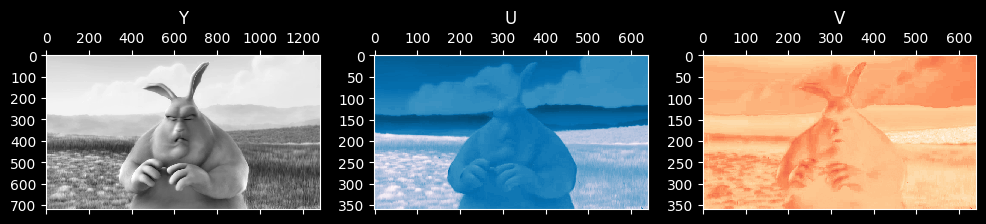

In [8]:
plot_yuv(*rgb2yuv(frame(5000)))

## Transform + Quantization

In [9]:
def M(QP: int) -> np.ndarray:
    m0 = [13107,11916,10082,9362,8192,7282][QP%6]
    m1 = [5243,4660,4194,3647,3355,2893][QP%6]
    m2 = [8066,7490,6554,5825,5243,4559][QP%6]
    return np.array([[m0,m2,m0,m2],[m2,m1,m2,m1],[m0,m2,m0,m2],[m2,m1,m2,m1]])

def transform(X: np.ndarray, QP=6) -> np.ndarray:
    C = np.array([[1,1,1,1],[2,1,-1,-2],[1,-1,-1,1],[1,-2,2,-1]])
    return np.fix(((C@X@C.T*M(QP)))/(2.**(15+(QP//6)))).astype(np.int64)


In [10]:
def V(QP: int) -> np.ndarray:
    v0 = [10,11,13,14,16,18][QP%6]
    v1 = [16,18,20,23,25,29][QP%6]
    v2 = [13,14,16,18,20,23][QP%6]
    return np.array([[v0,v2,v0,v2],[v2,v1,v2,v1],[v0,v2,v0,v2],[v2,v1,v2,v1]])

def inverse_transform(Y: np.ndarray, QP=6) -> np.ndarray:
    C = np.array([[1,1,1,1],[1,.5,-.5,-1],[1,-1,-1,1],[.5,-1,1,-.5]])
    return (((C.T@((Y*V(QP))<<(QP//6))@C).astype(np.int64)))>>6

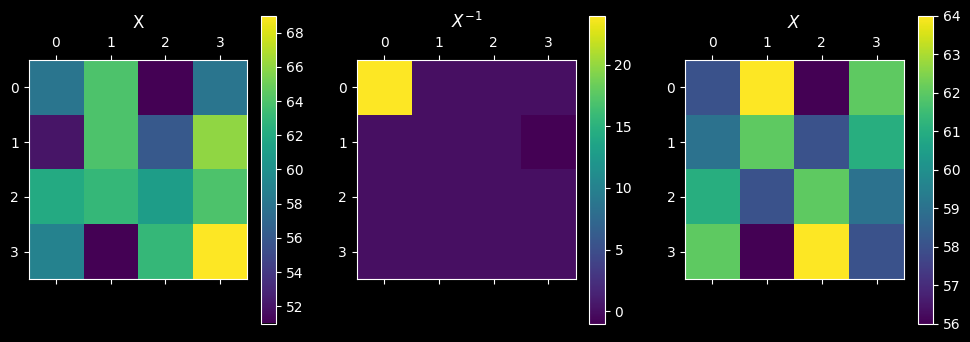

In [11]:
QP = 24
X = np.array([[58,64,51,58],[52,64,56,66],[62,63,61,64],[59,51,63,69]])
Y = transform(X, QP)
Z = inverse_transform(Y, QP)

# graph X and Y on two subplots with colorbars
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].title.set_text('X')
ax[1].title.set_text('$X^{{-1}}$')
ax[2].title.set_text('$X$')
fig.colorbar(ax[0].matshow(X), ax=ax[0])
fig.colorbar(ax[1].matshow(Y), ax=ax[1])
fig.colorbar(ax[2].matshow(Z), ax=ax[2])
plt.show()

## Lookup Tables

In [12]:
def load_lookup(infile):
    with open(infile, 'rb') as f:
        return pickle.load(f)

In [13]:
def create_lookup(infile, outfile):
    csv = pd.read_csv(infile,dtype=str,skipinitialspace=True).to_numpy()
    run_size = {v[0] : v[1] for v in csv}
    nums = np.arange(-2047,2048)
    bits = np.ceil(np.log2(np.abs(nums)+1)).astype(int)
    nums[nums<0] = (nums[nums<0]-1)&((1<<bits[nums<0])-1)
    y = np.vectorize(np.binary_repr)(nums, bits)
    y[2047] = ''
    out = dict()
    for run in np.arange(16):
        for value in np.arange(-2047,2048):
            if value == 0:
                continue
            size = bits[value+2047]
            key = f"{run:X}/{size:X}"
            if key in run_size:
                e = run_size[key]
                out[(run,value)] = bitarray(e + y[value+2047])
    out[(np.int64(0),np.int64(0))] = bitarray(run_size["0/0"])
    with open(outfile, 'wb') as f:
        pickle.dump(out, f)

In [14]:
create_lookup('../data/huffman.csv', '../data/huffman.pkl')

In [15]:
huffman_lookup = load_lookup('../data/huffman.pkl')

## Entropy Coding

In [16]:
# Create index arrays for rows and columns
z_rows = np.array([0,0,1,2,1,0,0,1,2,3,3,2,1,2,3,3])
z_cols = np.array([0,1,0,0,1,2,3,2,1,0,1,2,3,3,2,3])

def zigzag(X: np.ndarray) -> np.ndarray:
    return X.reshape(-1,4,4)[:,z_rows,z_cols].reshape(-1,16)

def unzigzag(Y: np.ndarray) -> np.ndarray:
    Y = Y.reshape(-1,16)
    X = np.zeros_like(Y).reshape(-1,4,4)
    X[:,z_rows,z_cols] = Y[:,:]
    return X

In [17]:
def count_zeros_between(X: np.ndarray) -> np.ndarray:
    nonzero_indices = np.nonzero(X)
    result = np.zeros_like(X, dtype=np.int64)
    diff = np.diff(nonzero_indices[1], prepend=-1)
    result[nonzero_indices] = diff - 1
    result[result < 0] = 0
    return result

def run_size_encode(X: np.ndarray) -> np.ndarray:
    return np.dstack([count_zeros_between(X), X])

In [18]:
def entropy_code(X: np.ndarray, s: bitarray) -> bitarray:
    Y = zigzag(X)
    Z = run_size_encode(Y)
    for block in Z.reshape(-1, 16, 2):
        written = 0
        for run, value in block:
            if run == 0 and value == 0 and written != 0:
                continue
            s.encode(huffman_lookup, [(run, value)])
            written += run + 1
        if written != 16:
            s.encode(huffman_lookup, [(np.int64(0),np.int64(0))])
    return s

In [19]:
def entropy_decode(s: bitarray) -> np.ndarray:
    ac = decodetree(huffman_lookup)
    X = []
    for run, value in s.decode(ac):
        if run == 0 and value == 0 and (len(X)%16) == 0:
            X.append(0)
            continue
        elif run == 0 and value == 0:
            left = (16-len(X))%16
            X.extend([0]*left)
            continue
        X.extend([0]*run)
        X.append(value)
    X = np.array(X)
    return unzigzag(X)

In [20]:
E = entropy_code(Y, bitarray())
E

bitarray('1101011000111111100101010')

In [21]:
D = entropy_decode(E)
D

array([[[24,  0,  0,  0],
        [ 0,  0,  0, -1],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]]])

## Encoding/Decoding Frames

In [22]:
def encode_frame(X: np.ndarray, QP: int, s: bitarray) -> bitarray:
    for plane in rgb2yuv(X):
        height, width = plane.shape
        hblocks, wblocks = height//4, width//4
        blocks = (
            plane
                .reshape(hblocks, 4, wblocks, 4)
                .transpose(0,2,1,3)
                .reshape(-1,4,4)
        )
        blocks = transform(blocks, QP)
        blocks[1:,0,0] = blocks[1:,0,0] - blocks[:-1,0,0]
        entropy_code(blocks, s)
    return s

In [23]:
def decode_plane(blocks: np.ndarray, QP: int, height: int, width: int) -> np.ndarray:
    hblocks, wblocks = height//4, width//4
    blocks[1:,0,0] = blocks[1:,0,0] + np.cumsum(blocks[:-1,0,0])
    blocks = inverse_transform(blocks, QP)
    return (
        blocks
            .reshape(hblocks, wblocks, 4, 4)
            .transpose(0,2,1,3)
            .reshape(height,width)
            .astype(np.uint8)
    )

def decode_frame(s: bitarray, QP: int, height: int, width: int) -> np.ndarray:
    X = entropy_decode(s).astype(np.int64)
    hblocks, wblocks = height//4, width//4
    y_blocks, u_blocks, v_blocks = (
        X[:hblocks*wblocks],
        X[hblocks*wblocks:hblocks*wblocks+(hblocks//2*wblocks//2)],
        X[hblocks*wblocks+(hblocks//2*wblocks//2):],
    )
    Y = decode_plane(y_blocks, QP, height, width)
    U = decode_plane(u_blocks, QP, height//2, width//2)
    V = decode_plane(v_blocks, QP, height//2, width//2)
    return yuv2rgb(Y,U,V)

In [30]:
F = frame(162)
encoded = encode_frame(F, 24, bitarray())

In [31]:
f"compression ratio: {len(encoded) / (1280*720*3*8):.2%}"

'compression ratio: 5.72%'

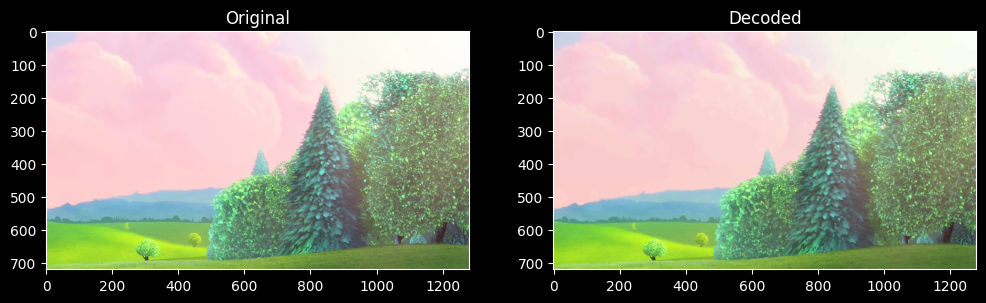

In [32]:
G = decode_frame(encoded, 24, 720, 1280)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].title.set_text('Original')
ax[1].title.set_text('Decoded')
ax[0].imshow(F)
ax[1].imshow(G)
plt.show()